# Model Visualization

In [163]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import models_mae

### Define utils

In [164]:
# define the utils

image_mean = np.array([0.4182007312774658, 0.4214799106121063, 0.3991275727748871])
image_std = np.array([0.28774282336235046, 0.27541765570640564, 0.2764017581939697])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * image_std + image_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch, **kwargs):
    # build model
    model = getattr(models_mae, arch)(**kwargs)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model, patch_size, channels=3):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y, p=patch_size, c=channels)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask, p=patch_size, c=channels)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

In [165]:
# load an image
# img_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRFQsDBSqgPKLHyunyQ0LJVDBXwzpnvWJqAOLPvVaUoA0xP-ZH4PPVCuyZtMllgEHSRTog&usqp=CAU'
# img_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQSEHLflglbuqe5FfipsPHIQHOSmDX46YBMQIt2yiIZteSj6k_bnnVtAgNGrSWIYAovuzM&usqp=CAU'
# img_data = requests.get(img_url, stream=True).raw
img_data = './images/0.jpg'
img = Image.open(img_data)

### Load a pre-trained MAE model

In [166]:
# download checkpoint if not exist
arch="mae_vit_small"
img_size = 64
patch_size = 8
attention="scaled_dot_product"

batch_size=768
epochs=200

checkpoint_folder = f"out_{arch}_i{img_size}_p{patch_size}_b{batch_size}_e{epochs}_{attention}"

checkpoint_dir = os.path.join("../Model_Saving", checkpoint_folder)
# List the directory and find the checkpoint with the highest epoch
checkpoint_list = os.listdir(checkpoint_dir)
checkpoint_list = [x for x in checkpoint_list if x.endswith(".pth")]
checkpoint_list.sort(key=lambda x: int(x.split("-")[1].split(".")[0]))
checkpoint_name = checkpoint_list[-1]
print("checkpoint_name: ", checkpoint_name)

chkpt_path = os.path.join(checkpoint_dir, checkpoint_name)
model_mae = prepare_model(chkpt_path, arch=arch, img_size=img_size, patch_size=patch_size, attention=attention)
print('Model loaded.')


checkpoint_name:  checkpoint-60.pth
Using xformers
<All keys matched successfully>
Model loaded.


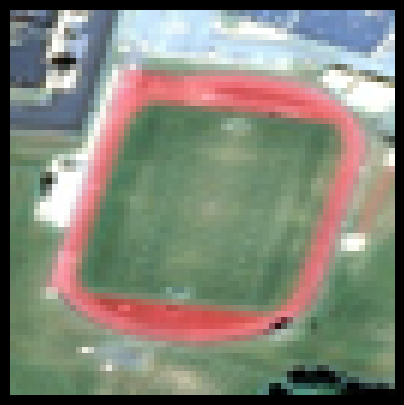

In [167]:
img = img.resize((img_size, img_size))
img = np.array(img) / 255.

assert img.shape == (img_size, img_size, 3)

# normalize by ImageNet mean and std
img = img - image_mean
img = img / image_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Run MAE on the image

MAE with pixel reconstruction:


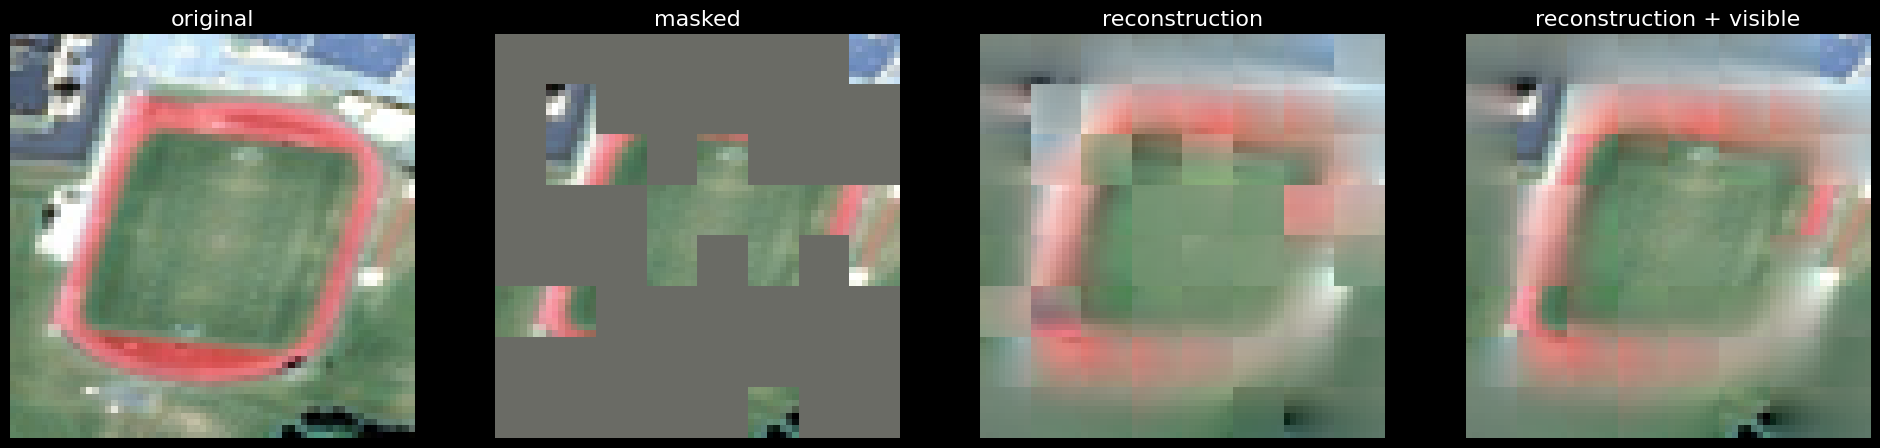

In [168]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae, patch_size=patch_size)